# Statistics Canada Analysis

## Summary

1-2 sentences description of analysis

## Introduction

Intro 

- Background info relating to the topic 
- Narrowing down of variables will be justified here
- Will use 3 references: Definitions of certain term(s), background info or inspiration for the study, narrowing down of variables due to prior research (hopefully from a peer reviewed article).

## Research Question

- How do family size and the major income earner in a family influence familial investment income

Predicting the economic family's investment income (EFINVA), based on the economic family's major earner (EFMJIE) and its size (EFSIZE)

## Dataset Description

Canadian Income Survey (CIS) is a cross-sectional survey sponsored both by the Government of Canada and Statistics Canada. The purpose of this survey is to collect information from all citizens and household within Canada, however around 2% of the residing on the reserve, aboriginal settlements or extremely remote areas with extremely small populations is not included in this survey. This survey collect the data from several different characteristics including labour market activity, school attendance, disability, support payments, child care expenses, inter-household transfers. This dataset also combine some information from the Labour Force Survey(LFS), such as the information about the education level ogeography information. This data set is available to all of the organization, different level of the government, and individuals. Different government could use this dataset to make ner economic well policies to all canadian.

#### Description of Relevent Variables

## Methods and Results

### Description of Methods

- The dataset was loaded, and the features of interest were identified to subset the data into columns containing only these features.
- The data was cleaned and wrangled according to results of EDA as well as information provided through the dataset description. 
- EDA was done to identify the distributions among the variables of interest and their correlations to each other.
- The data was split into a training set and a testing set using a 75/25 split since there was an abundant amount of observations.
- Within each split, the data was split into the features and the target variables. The features were "EPSIZE" (family size) and "EFMJIE" (major income earner in family), and the target was "EFINVA" (family investment income)
- Preprocessing was applied on the features of the training set to transform the categorical features "EFSIZE" (family size) and "EFMJIE" (major income earner in family) into numerical features. This was done using ordinal encoding for family size, and binary one hot encoding for the major income earner feature
- A linear regression pipeline using the Ridge model from sci-kit learn was applied using a 10 fold cross-validation score to obtain a mean training score
- The above was repeated for KNN regression
- The models were compared to identify the better 

# Preliminary Analysis

#### Loading the Data

In [1]:
# Importing the appropriate packages
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
# from mlxtend.plotting import plot_decision_regions 

In [2]:
# Loading the data
data = pd.read_csv('data/CIS-72M0003-E-2017-Annual/CIS-72M0003-E-2017-Annual_F1.csv')
data.head()

,YEAR,PUMFID,PERSONID,FWEIGHT,PROV,USZGAP,MBMREGP,AGEGP,SEX,MARST,...,DWLTYP,DWTENR,REPA,SUIT,MORTG,MORTGM,CONDMP,RENTM,CHNEED,VERDATE
0,2017,2129,212901,NaN,24,8,18,4,2,6,...,1,1,3,1,2,99999996,99999996,99999996,2,02JUL2019
1,2017,2129,212902,NaN,24,8,18,4,1,6,...,1,1,3,1,2,99999996,99999996,99999996,2,02JUL2019
2,2017,2129,212903,NaN,24,8,18,10,2,2,...,1,1,3,1,2,99999996,99999996,99999996,2,02JUL2019
3,2017,2129,212904,NaN,24,8,18,10,1,2,...,1,1,3,1,2,99999996,99999996,99999996,2,02JUL2019
4,2017,2130,213001,NaN,12,5,7,16,1,1,...,1,1,2,1,2,99999996,99999996,99999996,6,02JUL2019


# Cleaning and Wrangling

**The data is reduced to some specific features and targets of interest before EDA as it is difficult to analyze 194 features.**

In [3]:
reduced_data = data[['EFSIZE', 'USHRWK', 'ATINC', 'HLEV2G', 'EFINVA', 'EFMJIE', 'EFATINC', 'EFMJSI']]

### Figure 1: Dataframe containing only preliminary features of interest to do EDA on 

In [4]:
reduced_data

,EFSIZE,USHRWK,ATINC,HLEV2G,EFINVA,EFMJIE,EFATINC,EFMJSI
0,4,NaN,12075,1,375,2,132440,3
1,4,NaN,10530,1,375,2,132440,3
2,4,NaN,6250,2,375,2,132440,3
3,4,NaN,103585,2,375,1,132440,3
4,2,NaN,69570,3,850,1,71815,6
...,...,...,...,...,...,...,...,...
92287,7,NaN,99999996,6,0,2,53300,4
92288,7,NaN,99999996,6,0,2,53300,4
92289,7,NaN,99999996,6,0,2,53300,4
92290,2,NaN,35255,3,0,1,51685,3


In [5]:
reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92292 entries, 0 to 92291
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EFSIZE   92292 non-null  int64  
 1   USHRWK   0 non-null      float64
 2   ATINC    92292 non-null  int64  
 3   HLEV2G   92292 non-null  int64  
 4   EFINVA   92292 non-null  int64  
 5   EFMJIE   92292 non-null  int64  
 6   EFATINC  92292 non-null  int64  
 7   EFMJSI   92292 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 5.6 MB


- **The types are all numeric, but this does not mean the data are all numeric. When referring to the data set description, EFMJIE, EFMJSI, and HLEV2G are categorical variables with numbers corresponding to categories**
- **The USHRWK column has zero valid values as all are NaN. This is not an error as these were the values in the description of the dataset as well**


In [6]:
reduced_data.describe()

,EFSIZE,USHRWK,ATINC,HLEV2G,EFINVA,EFMJIE,EFATINC,EFMJSI
count,92292.000000,0.0,9.229200e+04,92292.000000,92292.000000,92292.000000,9.229200e+04,92292.000000
mean,2.958848,NaN,1.836557e+07,3.340268,5722.896351,1.553439,8.712786e+04,2.861949
std,1.451516,NaN,3.867862e+07,1.711394,29041.941551,0.497139,5.858689e+04,1.337363
min,1.000000,NaN,-7.039500e+04,1.000000,-64000.000000,1.000000,-3.985000e+04,2.000000
25%,2.000000,NaN,2.102375e+04,2.000000,0.000000,1.000000,4.749000e+04,2.000000
50%,3.000000,NaN,4.114750e+04,3.000000,0.000000,2.000000,7.629000e+04,2.000000
75%,4.000000,NaN,8.203625e+04,4.000000,400.000000,2.000000,1.134400e+05,4.000000
max,7.000000,NaN,1.000000e+08,9.000000,960000.000000,2.000000,1.128860e+06,7.000000


**The above summaries indicate no missing data for the columns except USHRWK (all non-null counts at 92292 which is in line with the number of total observations in the data). However, when referring to the dataset description, the ATINC column contains the value 99999996 for observations that were skipped for the information for valid reasons. Therefore, these observations should be removed**

In [7]:
reduced_data = reduced_data.drop(columns = 'USHRWK')

In [8]:
reduced_data = reduced_data.loc[reduced_data['ATINC'] != 99999996]

### Figure 2: Dataframe containing only valid observations for ATINC (After Tax Income) column.

In [9]:
reduced_data

,EFSIZE,ATINC,HLEV2G,EFINVA,EFMJIE,EFATINC,EFMJSI
0,4,12075,1,375,2,132440,3
1,4,10530,1,375,2,132440,3
2,4,6250,2,375,2,132440,3
3,4,103585,2,375,1,132440,3
4,2,69570,3,850,1,71815,6
...,...,...,...,...,...,...,...
92282,2,29540,1,1725,1,42235,4
92283,7,51000,1,0,1,53300,4
92284,7,2300,1,0,2,53300,4
92290,2,35255,3,0,1,51685,3


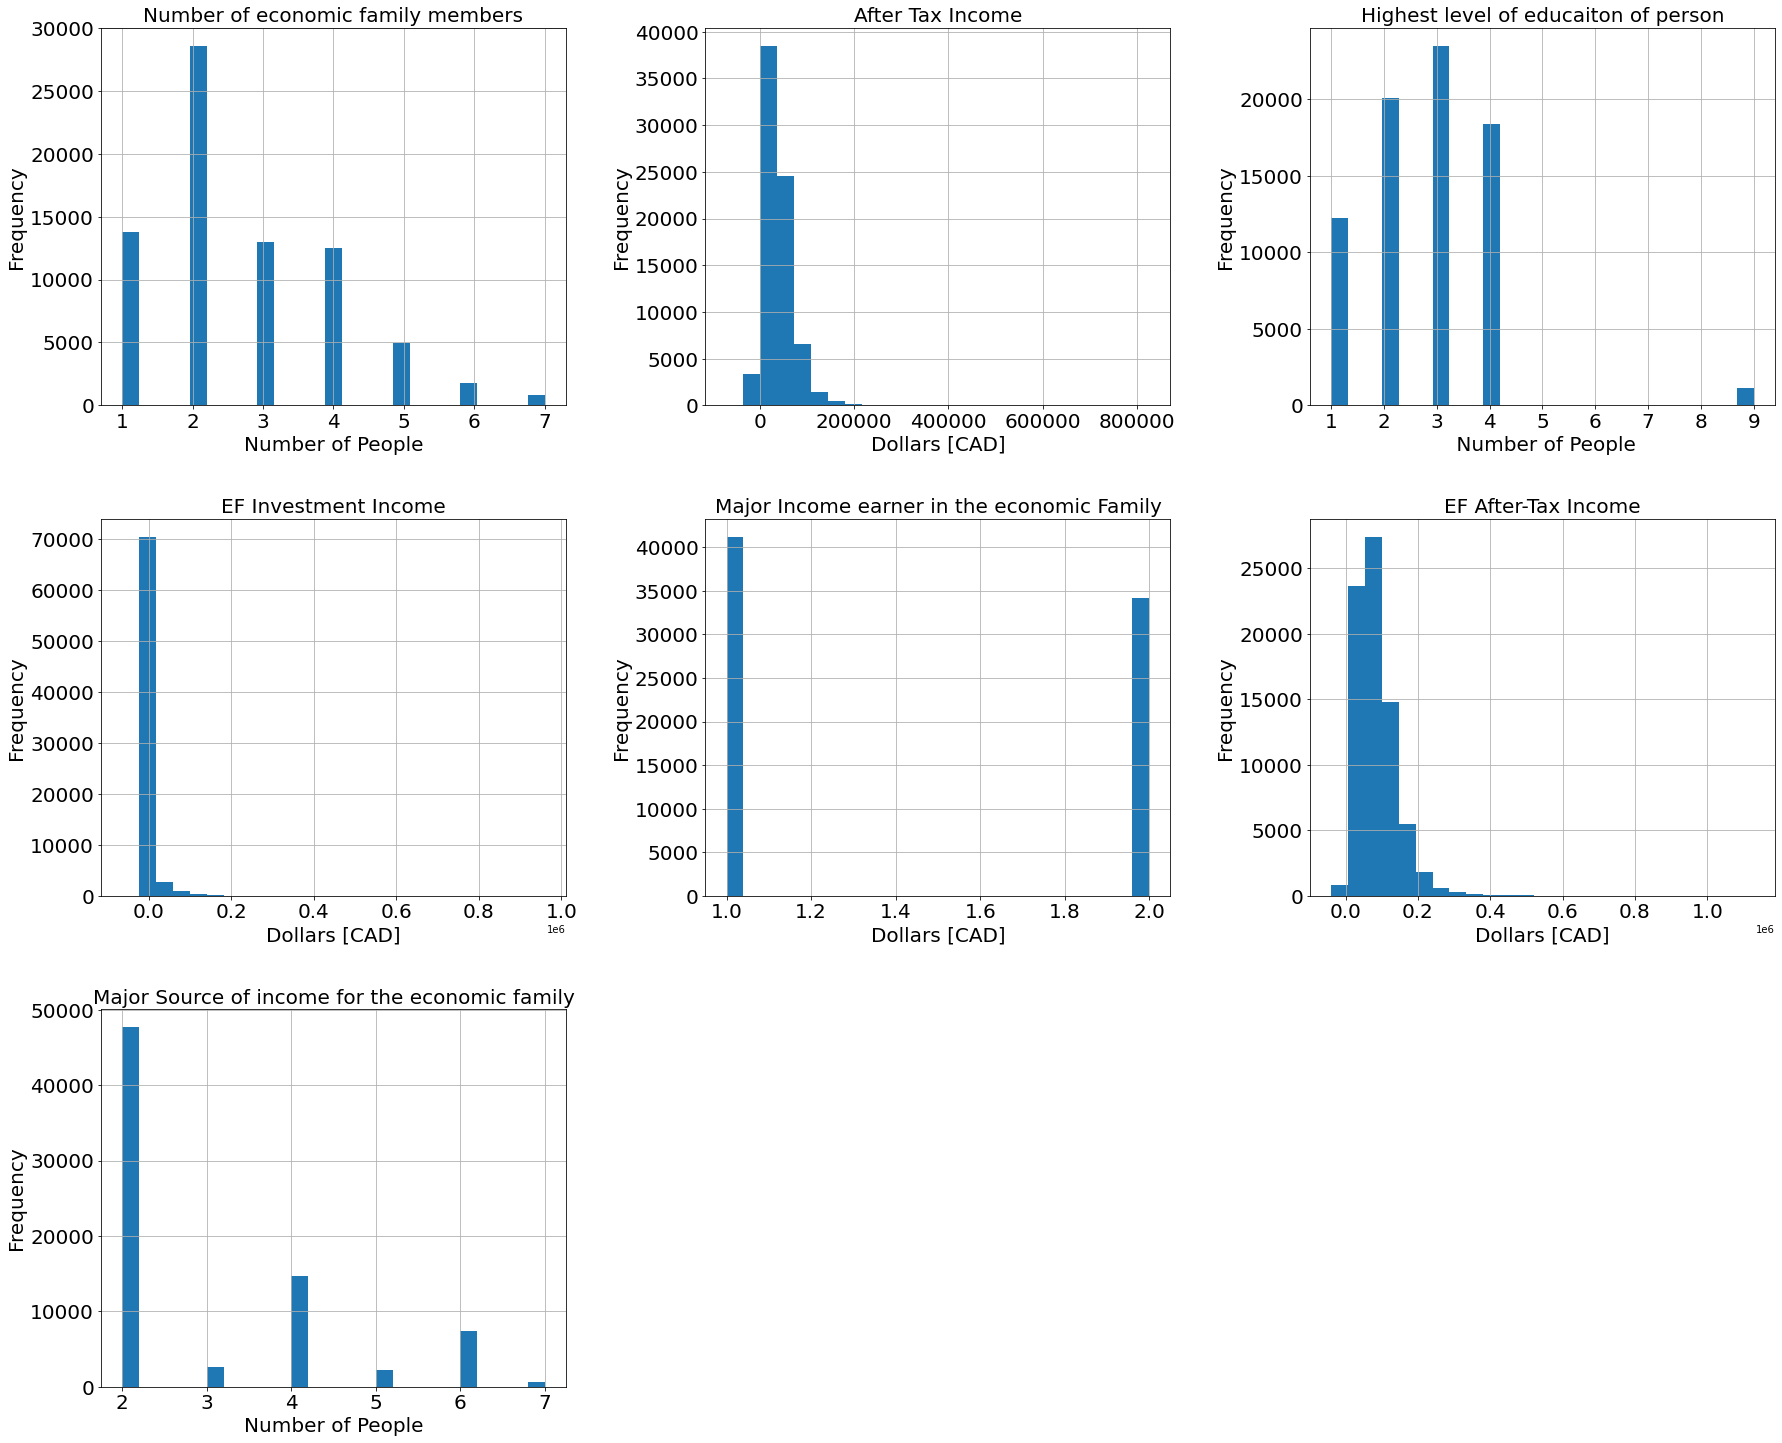

In [10]:
eda_feat_histograms = reduced_data.hist(bins=25, figsize=(30, 25))
texts = { 'titles':['Number of economic family members', 
                    'After Tax Income',
                    'Highest level of educaiton of person',
                    'EF Investment Income',
                    'Major Income earner in the economic Family',
                    'EF After-Tax Income',
                    'Major Source of income for the economic family' 
                    ],
            'xaxes':['Number of People',
                        'Dollars [CAD]',
                        ' Number of People',
                        'Dollars [CAD]',
                        'Dollars [CAD]',
                        'Dollars [CAD]',
                        'Number of People']
         }

#format histogram
for i, hist in enumerate(eda_feat_histograms.flatten()): 
    if (i == len(eda_feat_histograms.flatten()) - 2): break 
    hist.set_xlabel(texts['xaxes'][i])
    hist.set_title(texts['titles'][i])
    hist.set_ylabel('Frequency')
    for item in ([hist.title, hist.xaxis.label, hist.yaxis.label] +
             hist.get_xticklabels() + hist.get_yticklabels()):
        item.set_fontsize(20)

In [11]:
plt.figure(figsize=(10,10))
correlations = reduced_data.iloc[:,[1,3,5]].corr()

<Figure size 720x720 with 0 Axes>

### Figure 3: Matrix of correlations between various features. 
##### Note: correlations between categorical features should be ignored as these are invalid

<AxesSubplot:>

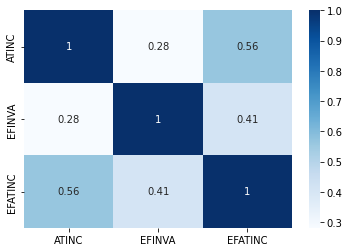

In [12]:
sns.heatmap(correlations, cmap=plt.cm.Blues, annot=True)

#### Visualisations

# Data Splitting and Preprocessing

In [13]:
processed = reduced_data[["EFINVA","EFSIZE","EFMJIE"]]

### Figure 4: Reduced dataframe of target variable investment income in CAD (EFINVA), and features family size (EFSIZE) and major income earner (EFMJIE)

In [14]:
processed

,EFINVA,EFSIZE,EFMJIE
0,375,4,2
1,375,4,2
2,375,4,2
3,375,4,1
4,850,2,1
...,...,...,...
92282,1725,2,1
92283,0,7,1
92284,0,7,2
92290,0,2,1


In [15]:
train, test = train_test_split(processed, test_size = 0.3, random_state=123)
X_train , Y_train = train.drop(columns = "EFINVA"), train["EFINVA"]
X_test, Y_test = test.drop(columns = "EFINVA"), test["EFINVA"]

**The features are identified as ordinal categorical for family size (EFSIZE) and binary for major income earner (EFMJIE). These are separated to apply different preprocessing steps**

In [16]:
binary_fea =["EFMJIE"]
cate_fea = ["EFSIZE"]

In [17]:
# make a pipe line for preprocessing the features above according to their types: ordinal vs binary
cate_trans = make_pipeline(OrdinalEncoder(categories = [[1, 2, 3, 4, 5, 6, 7]], dtype=int))
binary_trans = make_pipeline(OneHotEncoder(drop="if_binary"))
preprocessor = make_column_transformer(
    (binary_trans, binary_fea),
    (cate_trans,cate_fea)
)

train_processed = preprocessor.fit_transform(X_train)

### Figure 3: Resulting dataframe of features  after preprocessing steps

In [18]:
pd.DataFrame(train_processed, columns = ["EFMJIE","EFSIZE"])

,EFMJIE,EFSIZE
0,0.0,1.0
1,0.0,3.0
2,1.0,1.0
3,1.0,5.0
4,0.0,0.0
...,...,...
52755,0.0,3.0
52756,1.0,3.0
52757,0.0,0.0
52758,0.0,0.0


# Hyperparameter Optimization for Ridge Regression Model training

In [19]:
alphas = 10.0 ** np.arange(-2, 5, 1)
ridge_cv_pipe = make_pipeline(preprocessor, RidgeCV(alphas = alphas, cv=10))
ridge_cv_pipe.fit(X_train, Y_train)
best_alpha = ridge_cv_pipe.named_steps["ridgecv"].alpha_
best_alpha

1000.0

In [20]:
# Make pipeline using optimized alpha value
ridge_pipeline = make_pipeline(preprocessor, Ridge(alpha=best_alpha))

### Figure 4: Cross validation scores for ridge model

In [21]:
cv_ridge = pd.DataFrame(cross_validate(ridge_pipeline, X_train, Y_train, cv=10, return_train_score=True))
cv_ridge

,fit_time,score_time,test_score,train_score
0,0.021649,0.005272,-0.000788,0.003143
1,0.018904,0.004071,0.002393,0.002770
2,0.017497,0.003827,0.001446,0.002883
3,0.017491,0.003729,0.003275,0.002698
4,0.017787,0.003852,0.004520,0.002559
5,0.018317,0.004247,0.004505,0.002567
6,0.017757,0.003673,0.001703,0.002864
7,0.017782,0.003848,0.004025,0.002628
8,0.017813,0.003836,0.003311,0.002678
9,0.017437,0.003822,0.001946,0.002846


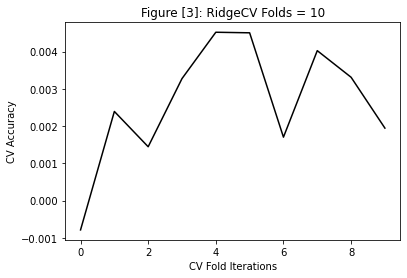

In [22]:
ridge = plt.plot(np.arange(len(cv_ridge)), 
                    cv_ridge['test_score'], 
                    '-0')
plt.title('Figure [3]: RidgeCV Folds = 10')
plt.xlabel('CV Fold Iterations')
plt.ylabel('CV Accuracy')
plt.show()

## Using Classification instead of Regression

In [23]:
# Wrangling
processed['EFINVA_Made_Money'] = np.array(processed['EFINVA']) > processed['EFINVA'].median()
processed

<ipython-input-23-d1a14d69ee05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed['EFINVA_Made_Money'] = np.array(processed['EFINVA']) > processed['EFINVA'].median()


,EFINVA,EFSIZE,EFMJIE,EFINVA_Made_Money
0,375,4,2,True
1,375,4,2,True
2,375,4,2,True
3,375,4,1,True
4,850,2,1,True
...,...,...,...,...
92282,1725,2,1,True
92283,0,7,1,False
92284,0,7,2,False
92290,0,2,1,False


In [24]:
#spitting the data set
train_2, test_2 = train_test_split(processed, test_size = 0.3, random_state=123)
X_train_2 , Y_train_2 = train_2.drop(columns = "EFINVA_Made_Money"), train_2["EFINVA_Made_Money"]
X_test_2, Y_test_2 = test_2.drop(columns = "EFINVA_Made_Money"), test_2["EFINVA_Made_Money"]

In [25]:
results_dict = {
        "n_neighbours": [], 
        "mean_train_score": [], 
        "mean_cv_score": []
}

param_grid = {"n_neighbours": np.arange(1,50, 5)}
for k in param_grid["n_neighbours"]:
    pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=k, n_jobs=-1))
    scores = cross_validate(pipe_knn, X_train_2, Y_train_2, return_train_score = True)  
    results_dict["n_neighbours"].append(k)
    results_dict["mean_train_score"].append(np.mean(scores['train_score']))
    results_dict["mean_cv_score"].append(np.mean(scores['test_score']))
results_df = pd.DataFrame(results_dict)

In [26]:
results_df

,n_neighbours,mean_train_score,mean_cv_score
0,1,0.488917,0.488552
1,6,0.570205,0.569617
2,11,0.532548,0.532051
3,16,0.561221,0.562111
4,21,0.536832,0.538040
5,26,0.553620,0.554795
6,31,0.561159,0.560159
7,36,0.564883,0.563476
8,41,0.564784,0.563874
9,46,0.573517,0.572479


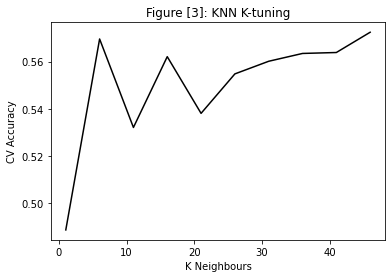

In [27]:
elbow_plt = plt.plot(results_df['n_neighbours'], 
                    results_df['mean_cv_score'], 
                    '-0')
plt.title('Figure [3]: KNN K-tuning')
plt.xlabel('K Neighbours')
plt.ylabel('CV Accuracy')
plt.show()

### Testing

In [29]:
pipe_final = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=26))
pipe_final.fit(X_train_2, Y_train_2)
pipe_final.score(X_test_2, Y_test_2)

0.5572704758535291

Visually comparing predictive results to true value

In [30]:
#create table to represent true value counts
X_test_2_processed = preprocessor.fit_transform(X_test_2)
complete_df = pd.DataFrame(X_test_2_processed, columns = ["EFMJIE","EFSIZE"])
#Appending Y axes back into pipedlined data
complete_df['EFINVA_Made_Money'] = processed['EFINVA_Made_Money']

#group by to count specific groups in dataframe
true_counts = pd.DataFrame(complete_df.groupby(['EFSIZE',
                                                'EFMJIE', 
                                                'EFINVA_Made_Money']).size().reset_index()
                          )
true_counts = true_counts.rename(columns={0:"counts"})
true_counts

,EFSIZE,EFMJIE,EFINVA_Made_Money,counts
0,0.0,0.0,False,1958
1,0.0,0.0,True,1374
2,1.0,0.0,False,2173
3,1.0,0.0,True,1506
4,1.0,1.0,False,1924
5,1.0,1.0,True,1457
6,2.0,0.0,False,800
7,2.0,0.0,True,587
8,2.0,1.0,False,1077
9,2.0,1.0,True,740


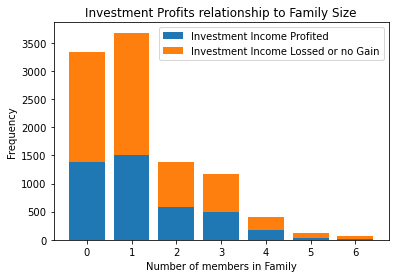

In [71]:
#bar showing the true profit based on family size for non-major income earners
bar_width = 0.35
is_major_income_earner = False
#get all family sizes
categories_profits = sorted(true_counts.loc[(true_counts['EFMJIE'] == is_major_income_earner) & 
                                            (true_counts['EFINVA_Made_Money'] == True)]['EFSIZE'].unique())
categories_loss = sorted(true_counts.loc[(true_counts['EFMJIE'] == is_major_income_earner) & 
                                         (true_counts['EFINVA_Made_Money'] == True)]['EFSIZE'].unique())
#separate counted data for plotting
p0_profits = true_counts.loc[(true_counts['EFMJIE'] == is_major_income_earner) & 
                             (true_counts['EFINVA_Made_Money'] == True)]['counts']
p0_loss = true_counts.loc[(true_counts['EFMJIE'] == is_major_income_earner) & 
                          (true_counts['EFINVA_Made_Money']== False)]['counts']
#plot counted data
p0_profits_plt = plt.bar(categories_profits, 
                         p0_profits, 
                         label = 'Investment Income Profited')
p0_loss_plt = plt.bar(categories_loss,
                      p0_loss,
                      bottom=p0_profits,
                      label = 'Investment Income Lossed or no Gain')

#stylize plot
plt.title('Investment Profits relationship to Family Size')
plt.ylabel('Frequency')
plt.xlabel('Number of members in Family')
plt.legend()

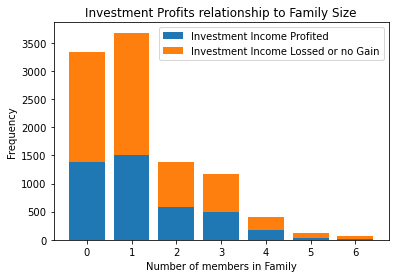

In [70]:
#bar showing the true profit based on family size for major income earners
bar_width = 0.35
is_major_income_earner = True
categories = sorted(true_counts['EFSIZE'].unique())
#separate counted data for plotting
p1_profits = true_counts.loc[(true_counts['EFMJIE'] == 1.0) & 
                             (true_counts['EFINVA_Made_Money'] == True)]['counts']
p1_loss = true_counts.loc[(true_counts['EFMJIE'] == 1.0) & 
                          (true_counts['EFINVA_Made_Money']== False)]['counts']
#plot counted data
p1_profits_plt = plt.bar(categories, p0_profits, label = 'Investment Income Profited')
p1_loss_plt = plt.bar(categories, p0_loss, bottom=p0_profits, label = 'Investment Income Lossed or no Gain')

#stylize plot
plt.title('Investment Profits relationship to Family Size')
plt.ylabel('Frequency')
plt.xlabel('Number of members in Family')
plt.legend()

In [34]:
#create table to represent predictive value counts
predictive_df = pd.DataFrame(X_test_2_processed, columns = ["EFMJIE","EFSIZE"])

#Appending models classified values
predictive_df['EFINVA_Made_Money_pred'] = pipe_final.predict(X_test_2)
# #group by to count specific groups in dataframe
predicted_counts = pd.DataFrame(predictive_df.groupby(['EFSIZE',
                                                'EFMJIE', 
                                                'EFINVA_Made_Money_pred']).size().reset_index()
                          )
predicted_counts = predicted_counts.rename(columns={0:"counts"})
predicted_counts

,EFSIZE,EFMJIE,EFINVA_Made_Money_pred,counts
0,0.0,0.0,False,4096
1,1.0,0.0,True,4505
2,1.0,1.0,False,4175
3,2.0,0.0,False,1667
4,2.0,1.0,False,2248
5,3.0,0.0,False,1428
6,3.0,1.0,False,2263
7,4.0,0.0,True,501
8,4.0,1.0,True,998
9,5.0,0.0,False,152


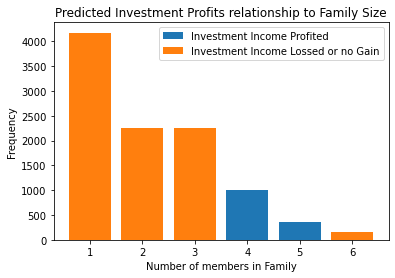

In [68]:
#bar showing the predicted profit based on family size for major income earners
bar_width = 0.35
is_major_income_earner = True
#Get all output x-axis output
categories_prof = sorted(predicted_counts.loc[(predicted_counts['EFMJIE'] == is_major_income_earner) & 
                                                   (predicted_counts['EFINVA_Made_Money_pred'] == True)
                                                  ]['EFSIZE'].unique())
categories_loss = sorted(predicted_counts.loc[(predicted_counts['EFMJIE'] == is_major_income_earner) & 
                                                   (predicted_counts['EFINVA_Made_Money_pred'] == False)
                                                  ]['EFSIZE'].unique())

#separate counted data for plotting
p1_profits_pred = predicted_counts.loc[(predicted_counts['EFMJIE'] == is_major_income_earner) & 
                                       (predicted_counts['EFINVA_Made_Money_pred'] == True)]['counts']
p1_loss_pred = predicted_counts.loc[(predicted_counts['EFMJIE'] == is_major_income_earner) & 
                                    (predicted_counts['EFINVA_Made_Money_pred']== False)]['counts']
# plot counted data
p1_profits_pred_plt = plt.bar(categories_prof, 
                              p1_profits_pred, label = 'Investment Income Profited')
p1_loss_pred_plt = plt.bar(categories_loss, 
                           p1_loss_pred, 
                           # bottom=p1_profits_pred,
                           label = 'Investment Income Lossed or no Gain')

#stylize plot
plt.title('Predicted Investment Profits relationship to Family Size')
plt.ylabel('Frequency')
plt.xlabel('Number of members in Family')
plt.legend()

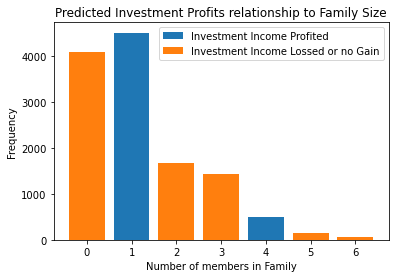

In [69]:
#bar showing the predicted profit based on family size for non-major income earners
bar_width = 0.35
is_major_income_earner = False
#Get all output x-axis output
categories_prof = sorted(predicted_counts.loc[(predicted_counts['EFMJIE'] == is_major_income_earner) & 
                                                   (predicted_counts['EFINVA_Made_Money_pred'] == True)
                                                  ]['EFSIZE'].unique())
categories_loss = sorted(predicted_counts.loc[(predicted_counts['EFMJIE'] == is_major_income_earner) & 
                                                   (predicted_counts['EFINVA_Made_Money_pred'] == False)
                                                  ]['EFSIZE'].unique())

#separate counted data for plotting
p1_profits_pred = predicted_counts.loc[(predicted_counts['EFMJIE'] == is_major_income_earner) & 
                                       (predicted_counts['EFINVA_Made_Money_pred'] == True)]['counts']
p1_loss_pred = predicted_counts.loc[(predicted_counts['EFMJIE'] == is_major_income_earner) & 
                                    (predicted_counts['EFINVA_Made_Money_pred']== False)]['counts']
# plot counted data
p1_profits_pred_plt = plt.bar(categories_prof, 
                              p1_profits_pred, label = 'Investment Income Profited')
p1_loss_pred_plt = plt.bar(categories_loss, 
                           p1_loss_pred, 
                           label = 'Investment Income Lossed or no Gain')

#stylize plot
plt.title('Predicted Investment Profits relationship to Family Size')
plt.ylabel('Frequency')
plt.xlabel('Number of members in Family')
plt.legend()

## Discussion of Results

## References